### 1, Importing necessary libraries

In [11]:
import os
import requests
import zipfile
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
import matplotlib.pyplot as plt

In [36]:
# Defining the dataset path
dataset_path = 'BirdVsDroneDetection.v2i.yolov8/'

In [13]:
# Load dataset paths from data.yaml file provided by Roboflow
train_image_folder = os.path.join(dataset_path, 'train/images')
val_image_folder = os.path.join(dataset_path, 'valid/images')


### 2. Data Preprocessing

In [14]:
# Define the function for preprocessing of image
def preprocess_image(image_path, size=(640, 640)):
    """
    Preprocess an image by resizing and normalizing it.
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image, size)
    image_normalized = image_resized / 255.0
    return image_normalized

In [15]:
# Example preprocessing
preprocessed_image = preprocess_image(os.path.join(train_image_folder, os.listdir(train_image_folder)[0]))

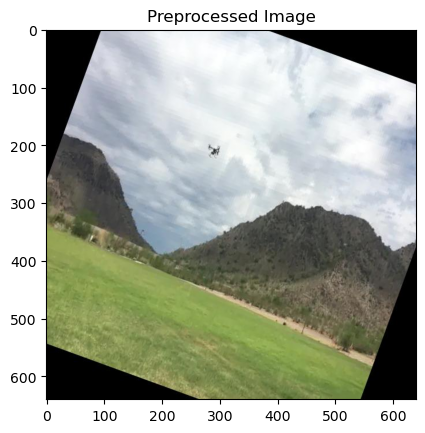

In [16]:
# Display preprocessed image
plt.imshow(preprocessed_image)
plt.title("Preprocessed Image")
plt.show()

### 3. Load YOLOV8 pretrained model and Train the Model

In [17]:
# Load YOLOv8 pre-trained model
model = YOLO('yolov8m.pt')  # Upgraded to YOLOv8 medium version for better accuracy

In [18]:
# Use the data.yaml file generated by Roboflow
data_yaml_path = 'BirdVsDroneDetection.v2i.yolov8/data.yaml'

In [ ]:
# Fine-tune the model on the dataset
# Use a smaller learning rate for fine-tuning
model.train(data=data_yaml_path, epochs=20, imgsz=640, batch=8, device='cpu', lr0=0.001)

In [20]:
# Checking for the Imbalance in the Dataset

import collections

# Define paths to label folders
train_label_folder = os.path.join(dataset_path, 'train/labels')
val_label_folder = os.path.join(dataset_path, 'valid/labels')

# Function to count class occurrences in label files
def count_class_occurrences(label_folder):
    class_counts = collections.defaultdict(int)
    for label_file in os.listdir(label_folder):
        if label_file.endswith('.txt'):
            with open(os.path.join(label_folder, label_file), 'r') as file:
                for line in file:
                    class_id = int(line.split()[0])  # Extract class ID (first element of each line)
                    class_counts[class_id] += 1
    return class_counts

# Count class occurrences in training and validation sets
train_class_counts = count_class_occurrences(train_label_folder)
val_class_counts = count_class_occurrences(val_label_folder)

# Print class counts
print("Training Set Class Counts:", train_class_counts)
print("Validation Set Class Counts:", val_class_counts)

# Check for imbalance
bird_class_id = 0  # Assuming Bird is class 0
drone_class_id = 1  # Assuming Drone is class 1

train_bird_count = train_class_counts[bird_class_id]
train_drone_count = train_class_counts[drone_class_id]

if train_bird_count != train_drone_count:
    print(f"Class imbalance detected in the training set: Bird = {train_bird_count}, Drone = {train_drone_count}")
else:
    print("No class imbalance detected in the training set.")

val_bird_count = val_class_counts[bird_class_id]
val_drone_count = val_class_counts[drone_class_id]

if val_bird_count != val_drone_count:
    print(f"Class imbalance detected in the validation set: Bird = {val_bird_count}, Drone = {val_drone_count}")
else:
    print("No class imbalance detected in the validation set.")


Training Set Class Counts: defaultdict(<class 'int'>, {1: 986, 0: 2566})
Validation Set Class Counts: defaultdict(<class 'int'>, {1: 87, 0: 157})
Class imbalance detected in the training set: Bird = 2566, Drone = 986
Class imbalance detected in the validation set: Bird = 157, Drone = 87


In [21]:
tracker = DeepSort(max_age=30, n_init=3, nms_max_overlap=1.0, embedder="mobilenet")

### 4, Model Evaluation

In [25]:
# Evaluate model on validation dataset
metrics = model.val()
print("Evaluation Metrics:")
mean_precision, mean_recall, mean_map50, mean_map = metrics.mean_results()
print(f"Precision: {mean_precision}")
print(f"Recall: {mean_recall}")
print(f"mAP@50: {mean_map50}")
print(f"mAP@50-95: {mean_map}")

Ultralytics 8.3.15 🚀 Python-3.11.5 torch-2.0.1 CPU (Apple M1)


val: Scanning /Users/ritikagupta/Desktop/BirdVsDroneDetection/BirdVsDroneDetection.v2i.yolov8/valid/labels.cache... 156 images, 0 backgrounds, 0 corrupt: 100%|██████████| 156/156 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 4, len(boxes) = 244. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [01:17<00:00,  3.89s/it]


                   all        156        244      0.874      0.726      0.816      0.478
                  Bird         73        157      0.769      0.635      0.706      0.351
                 Drone         83         87      0.979      0.816      0.926      0.604
Speed: 1.0ms preprocess, 491.6ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to /Users/ritikagupta/runs/detect/train382
Evaluation Metrics:
Precision: 0.8736147237654449
Recall: 0.7255399414545873
mAP@50: 0.8157200855870225
mAP@50-95: 0.47772248518989596


### 5. Saving the Model

In [63]:
import torch
import os

# Define the path where you want to save the model
save_path = '/Users/ritikagupta/runs/detect/train40/weights/best.pt'

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the model weights manually using PyTorch's save function
torch.save(model.model.state_dict(), save_path)

print(f"Model saved successfully at {save_path}")




Model saved successfully at /Users/ritikagupta/runs/detect/train40/weights/best.pt


### 6. Performing Detection on Synthetc Image Created

In [42]:
import cv2
import os

# Step 1: Create a synthetic video from dataset images
dataset_path = 'BirdVsDroneDetection.v2i.yolov8/'
image_folder = os.path.join(dataset_path, 'valid/images')
synthetic_video_name = 'synthetic_video.mp4'

# Gather all images (assuming image extensions as .jpg, .jpeg, or .png)
images = [img for img in sorted(os.listdir(image_folder)) if img.endswith(('.jpg', '.jpeg', '.png'))]
if not images:
    raise FileNotFoundError("No valid images found in the specified folder.")

# Get the size of the frames from the first image
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

# Create a video writer to store the synthetic video
synthetic_video = cv2.VideoWriter(synthetic_video_name, cv2.VideoWriter_fourcc(*'mp4v'), 10, (width, height))

# Loop through each image and add it as a frame to the video
for image in images:
    frame = cv2.imread(os.path.join(image_folder, image))
    synthetic_video.write(frame)

# Release video writer and cleanup
synthetic_video.release()
cv2.destroyAllWindows()

print(f"Synthetic video created: {synthetic_video_name}")

# Step 2: Process the synthetic video for YOLO detections and save the detected video

# Define output video name for detections
detected_video_name = 'detected_video.mp4'

# Video capture for tracking
cap = cv2.VideoCapture(synthetic_video_name)  # Open the synthetic video

# Ensure the video opened successfully
if not cap.isOpened():
    print(f"Error: Could not open video {synthetic_video_name}")
    exit()

# Create video writer for saving detection video
output_video = cv2.VideoWriter(detected_video_name, cv2.VideoWriter_fourcc(*'mp4v'), 10, (width, height))

# Loop through video frames
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Get YOLO detections (assuming `model` is your YOLO model)
    results = model(frame)
    detections = []
    for result in results:
        for data in result.boxes.data.tolist():
            if len(data) >= 6:
                xyxy = data[:4]
                conf = data[4]
                cls = int(data[5])
                detections.append([*xyxy, conf, cls])

    # Draw YOLO detections on the frame
    for detection in detections:
        x1, y1, x2, y2, conf, cls = detection
        label = 'Bird' if cls == 0 else 'Drone'
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(frame, f'{label} {conf:.2f}', (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

    # Write the frame with detections to the output video
    output_video.write(frame)

    # Optionally display the video frame with detection (comment out if not needed)
    # cv2.imshow('Frame', frame)
    # if cv2.waitKey(1) & 0xFF == ord('q'):
    #     break

# Release video capture and writer
cap.release()
output_video.release()
cv2.destroyAllWindows()

print(f"Detection video saved as: {detected_video_name}")


Synthetic video created: synthetic_video.mp4

0: 640x640 1 Drone, 464.8ms
Speed: 23.0ms preprocess, 464.8ms inference, 19.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Drone, 360.8ms
Speed: 1.6ms preprocess, 360.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Drone, 347.9ms
Speed: 1.4ms preprocess, 347.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Bird, 1 Drone, 352.1ms
Speed: 2.1ms preprocess, 352.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Drones, 349.6ms
Speed: 1.9ms preprocess, 349.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Drone, 358.1ms
Speed: 1.8ms preprocess, 358.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Drone, 423.9ms
Speed: 1.5ms preprocess, 423.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Drone, 377.7ms
Speed: 2.3ms preprocess, 3


0: 640x640 3 Birds, 1 Drone, 331.0ms
Speed: 1.6ms preprocess, 331.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Bird, 326.7ms
Speed: 1.6ms preprocess, 326.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Bird, 378.2ms
Speed: 2.0ms preprocess, 378.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Bird, 387.4ms
Speed: 1.6ms preprocess, 387.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Bird, 353.2ms
Speed: 1.6ms preprocess, 353.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Bird, 334.9ms
Speed: 1.8ms preprocess, 334.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Bird, 356.3ms
Speed: 1.8ms preprocess, 356.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Drone, 341.3ms
Speed: 2.1ms preprocess, 341.3ms inference, 0.7ms postprocess per image at shap

Speed: 1.7ms preprocess, 331.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Birds, 1 Drone, 317.2ms
Speed: 1.2ms preprocess, 317.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Drone, 372.9ms
Speed: 1.4ms preprocess, 372.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Drone, 489.9ms
Speed: 1.5ms preprocess, 489.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Drone, 356.3ms
Speed: 1.9ms preprocess, 356.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Drone, 321.9ms
Speed: 1.5ms preprocess, 321.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Drones, 330.4ms
Speed: 1.3ms preprocess, 330.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Bird, 1 Drone, 358.4ms
Speed: 1.6ms preprocess, 358.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 

In [64]:
import torch

# Define the path where you want to save the model
model_path = '/Users/ritikagupta/runs/detect/model_with_architecture.pt'

# Save the entire model (this includes both the architecture and the weights)
torch.save(model, model_path)

print(f"Model with architecture saved at: {model_path}")


Model with architecture saved at: /Users/ritikagupta/runs/detect/model_with_architecture.pt


In [2]:
import torch

# Path to the saved model
model_path = '/Users/ritikagupta/runs/detect/model_with_architecture.pt'

# Load the entire model (architecture + weights)
model = torch.load(model_path) 

# Set the model to evaluation mode
model.eval()

print("Model architecture and weights loaded successfully.")


New https://pypi.org/project/ultralytics/8.3.18 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.15 🚀 Python-3.11.5 torch-2.0.1 CPU (Apple M1)
engine/trainer: task=detect, mode=train, model=yolov8m.yaml, data=coco8.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train46, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_con

train: Scanning /Users/ritikagupta/datasets/coco8/labels/train.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /Users/ritikagupta/datasets/coco8/labels/val.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]

Plotting labels to /Users/ritikagupta/runs/detect/train46/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 83 weight(decay=0.0), 90 weight(decay=0.0005), 89 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /Users/ritikagupta/runs/detect/train46
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      3.308      5.419      4.195         19        640: 100%|██████████| 1/1 [00:06<00:00,  6.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      3.302      5.678      4.246         34        640: 100%|██████████| 1/1 [00:06<00:00,  6.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G          3      5.719      4.305         29        640: 100%|██████████| 1/1 [00:06<00:00,  6.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      3.058       5.42      4.331         20        640: 100%|██████████| 1/1 [00:05<00:00,  5.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G       3.62      5.525      4.191         29        640: 100%|██████████| 1/1 [00:06<00:00,  6.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      2.973      5.618      4.487         28        640: 100%|██████████| 1/1 [00:05<00:00,  5.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      2.957      5.437      4.238         22        640: 100%|██████████| 1/1 [00:05<00:00,  5.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G      3.691       5.74      4.187         23        640: 100%|██████████| 1/1 [00:06<00:00,  6.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G      3.023      5.549      4.271         21        640: 100%|██████████| 1/1 [00:05<00:00,  5.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G      3.101      5.579      4.186         34        640: 100%|██████████| 1/1 [00:05<00:00,  5.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      3.327      5.478      4.233         36        640: 100%|██████████| 1/1 [00:06<00:00,  6.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G      3.047      5.738      4.283         32        640: 100%|██████████| 1/1 [00:05<00:00,  5.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      3.376      5.656      4.208         33        640: 100%|██████████| 1/1 [00:05<00:00,  5.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G      3.434      5.393      4.202         34        640: 100%|██████████| 1/1 [00:06<00:00,  6.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G      3.247      5.664      4.192         15        640: 100%|██████████| 1/1 [00:05<00:00,  5.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G      3.136      5.558      4.247         15        640: 100%|██████████| 1/1 [00:06<00:00,  6.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G      3.179      5.472      4.257         27        640: 100%|██████████| 1/1 [00:06<00:00,  6.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G      3.504      5.737      4.317         22        640: 100%|██████████| 1/1 [00:06<00:00,  6.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G      3.364      5.628      4.222         34        640: 100%|██████████| 1/1 [00:06<00:00,  6.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G      2.821        5.8      4.287         25        640: 100%|██████████| 1/1 [00:06<00:00,  6.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.15s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G      3.192      5.717      4.266         33        640: 100%|██████████| 1/1 [00:06<00:00,  6.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G      3.243      5.655      4.214         23        640: 100%|██████████| 1/1 [00:06<00:00,  6.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G      3.213       5.51        4.2         21        640: 100%|██████████| 1/1 [00:06<00:00,  6.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G      3.608      5.503       4.26         29        640: 100%|██████████| 1/1 [00:05<00:00,  5.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G        3.3      5.437      4.192         53        640: 100%|██████████| 1/1 [00:06<00:00,  6.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G      3.178      5.767       4.31         20        640: 100%|██████████| 1/1 [00:06<00:00,  6.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G      3.585      5.581      4.225         20        640: 100%|██████████| 1/1 [00:06<00:00,  6.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G      3.168      5.573      4.246         29        640: 100%|██████████| 1/1 [00:06<00:00,  6.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G       3.62      5.595      4.183         30        640: 100%|██████████| 1/1 [00:06<00:00,  6.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G      3.003      5.452      4.307         24        640: 100%|██████████| 1/1 [00:05<00:00,  5.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G      3.164      5.542      4.213         28        640: 100%|██████████| 1/1 [00:12<00:00, 12.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G      2.949      5.816      4.343         23        640: 100%|██████████| 1/1 [00:06<00:00,  6.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G      2.783      5.563      4.257         44        640: 100%|██████████| 1/1 [00:06<00:00,  6.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G      3.153      5.621      4.186         21        640: 100%|██████████| 1/1 [00:05<00:00,  5.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G      3.642      5.694      4.276         16        640: 100%|██████████| 1/1 [00:06<00:00,  6.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G       3.09      5.768      4.243         19        640: 100%|██████████| 1/1 [00:05<00:00,  5.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G      3.461      5.502      4.294         26        640: 100%|██████████| 1/1 [00:07<00:00,  7.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G      2.738      5.442      4.273         28        640: 100%|██████████| 1/1 [00:06<00:00,  6.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G      3.379      5.573      4.229         29        640: 100%|██████████| 1/1 [00:07<00:00,  7.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G      3.057       5.48      4.236         27        640: 100%|██████████| 1/1 [00:06<00:00,  6.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G      3.491      5.449      4.185         33        640: 100%|██████████| 1/1 [00:06<00:00,  6.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G      3.449       5.58      4.218         35        640: 100%|██████████| 1/1 [00:06<00:00,  6.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.23s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G      3.318       5.58      4.214         21        640: 100%|██████████| 1/1 [00:06<00:00,  6.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G      2.961       5.51      4.239         46        640: 100%|██████████| 1/1 [00:05<00:00,  5.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G       2.98      5.447       4.21         31        640: 100%|██████████| 1/1 [00:06<00:00,  6.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G      2.832       5.58      4.196         41        640: 100%|██████████| 1/1 [00:06<00:00,  6.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G      3.178      5.548      4.211         41        640: 100%|██████████| 1/1 [00:07<00:00,  7.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G        3.1       5.54      4.197         44        640: 100%|██████████| 1/1 [00:06<00:00,  6.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G      2.945      5.642      4.204         32        640: 100%|██████████| 1/1 [00:06<00:00,  6.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G      3.305      5.405      4.279         24        640: 100%|██████████| 1/1 [00:06<00:00,  6.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G      3.455      5.662      4.226         23        640: 100%|██████████| 1/1 [00:06<00:00,  6.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G      3.596      5.462      4.286         19        640: 100%|██████████| 1/1 [00:05<00:00,  5.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G      3.425      5.623      4.175         22        640: 100%|██████████| 1/1 [00:06<00:00,  6.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.34s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G      2.908      5.448      4.247         15        640: 100%|██████████| 1/1 [00:06<00:00,  6.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G      2.757      5.708      4.252         23        640: 100%|██████████| 1/1 [00:07<00:00,  7.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.47s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G      3.721      5.616      4.222         28        640: 100%|██████████| 1/1 [00:08<00:00,  8.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G      3.457      5.549      4.179         24        640: 100%|██████████| 1/1 [00:06<00:00,  6.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         0G      3.447      5.479      4.228         28        640: 100%|██████████| 1/1 [00:06<00:00,  6.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100         0G      3.339      5.469      4.205         18        640: 100%|██████████| 1/1 [00:05<00:00,  5.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.22s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         0G      3.613      5.644      4.199         20        640: 100%|██████████| 1/1 [00:06<00:00,  6.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100         0G      3.364      5.469      4.211         24        640: 100%|██████████| 1/1 [00:06<00:00,  6.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.40s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G      3.105      5.607      4.216         32        640: 100%|██████████| 1/1 [00:08<00:00,  8.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.55s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100         0G      3.183      5.429      4.213         37        640: 100%|██████████| 1/1 [00:08<00:00,  8.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         0G      3.335      5.452       4.26         19        640: 100%|██████████| 1/1 [00:06<00:00,  6.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         0G      3.424      5.719      4.286         18        640: 100%|██████████| 1/1 [00:05<00:00,  5.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100         0G      2.995      5.488      4.208         21        640: 100%|██████████| 1/1 [00:05<00:00,  5.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         0G      3.112      5.466      4.206         43        640: 100%|██████████| 1/1 [00:05<00:00,  5.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100         0G      2.931      5.573      4.217         31        640: 100%|██████████| 1/1 [00:06<00:00,  6.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100         0G      2.709      5.543      4.227         26        640: 100%|██████████| 1/1 [00:06<00:00,  6.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         0G      3.432      5.556      4.169         23        640: 100%|██████████| 1/1 [00:05<00:00,  5.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100         0G      3.517      5.478      4.278         25        640: 100%|██████████| 1/1 [00:06<00:00,  6.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100         0G      3.075       5.52      4.164         23        640: 100%|██████████| 1/1 [00:09<00:00,  9.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.56s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100         0G        3.3      5.322      4.201         42        640: 100%|██████████| 1/1 [00:09<00:00,  9.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.27s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100         0G      3.429      5.556      4.266         25        640: 100%|██████████| 1/1 [00:07<00:00,  7.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100         0G      2.859      5.494      4.177         28        640: 100%|██████████| 1/1 [00:05<00:00,  5.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100         0G      3.088       5.53      4.199         27        640: 100%|██████████| 1/1 [00:05<00:00,  5.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100         0G      3.554      5.488      4.342         36        640: 100%|██████████| 1/1 [00:06<00:00,  6.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100         0G      2.995      5.444      4.194         35        640: 100%|██████████| 1/1 [00:06<00:00,  6.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100         0G      2.925      5.536      4.256         35        640: 100%|██████████| 1/1 [00:05<00:00,  5.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100         0G      3.677      5.462      4.192         23        640: 100%|██████████| 1/1 [00:05<00:00,  5.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100         0G      2.944      5.476       4.19         31        640: 100%|██████████| 1/1 [00:06<00:00,  6.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.20s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100         0G       3.21      5.407      4.192         25        640: 100%|██████████| 1/1 [00:06<00:00,  6.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100         0G      3.115      5.546      4.151         19        640: 100%|██████████| 1/1 [00:05<00:00,  5.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100         0G       3.73      5.404      4.182         42        640: 100%|██████████| 1/1 [00:06<00:00,  6.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.06s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100         0G      3.484      5.297      4.223         37        640: 100%|██████████| 1/1 [00:05<00:00,  5.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100         0G      3.783       5.51      4.225         27        640: 100%|██████████| 1/1 [00:06<00:00,  6.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100         0G      3.118      5.261      4.244         29        640: 100%|██████████| 1/1 [00:06<00:00,  6.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100         0G      2.849      5.622      4.185         25        640: 100%|██████████| 1/1 [00:06<00:00,  6.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100         0G      3.397      5.393      4.244         19        640: 100%|██████████| 1/1 [00:05<00:00,  5.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100         0G      3.418      5.561      4.233         28        640: 100%|██████████| 1/1 [00:06<00:00,  6.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]

                   all          4         17          0          0          0          0


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100         0G      2.628       5.53      4.211         13        640: 100%|██████████| 1/1 [00:05<00:00,  5.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100         0G      2.561      5.544       4.21         13        640: 100%|██████████| 1/1 [00:06<00:00,  6.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100         0G      2.364      6.142      4.395         13        640: 100%|██████████| 1/1 [00:05<00:00,  5.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.93s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100         0G      2.752      5.439      4.204         13        640: 100%|██████████| 1/1 [00:06<00:00,  6.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100         0G      2.949       5.85      4.246         13        640: 100%|██████████| 1/1 [00:05<00:00,  5.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100         0G      2.617       6.06      4.251         13        640: 100%|██████████| 1/1 [00:05<00:00,  5.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100         0G      2.952      5.611      4.178         13        640: 100%|██████████| 1/1 [00:05<00:00,  5.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100         0G      2.859      5.445      4.173         13        640: 100%|██████████| 1/1 [00:05<00:00,  5.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100         0G      3.216      5.549      4.168         13        640: 100%|██████████| 1/1 [00:05<00:00,  5.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100         0G       2.97      5.586      4.223         13        640: 100%|██████████| 1/1 [00:06<00:00,  6.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]

                   all          4         17          0          0          0          0



100 epochs completed in 0.261 hours.
Optimizer stripped from /Users/ritikagupta/runs/detect/train46/weights/last.pt, 46.9MB
Optimizer stripped from /Users/ritikagupta/runs/detect/train46/weights/best.pt, 46.9MB

Validating /Users/ritikagupta/runs/detect/train46/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.15 🚀 Python-3.11.5 torch-2.0.1 CPU (Apple M1)
YOLOv8m summary (fused): 236 layers, 23,249,152 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]

                   all          4         17          0          0          0          0


Speed: 0.7ms preprocess, 455.8ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /Users/ritikagupta/runs/detect/train46
Model architecture and weights loaded successfully.


### 7. Performing Quantisation

In [25]:
from ultralytics import YOLO

# Load the model architecture
model = YOLO('yolov8m.yaml')

# Manually load the weights
state_dict = torch.load('/Users/ritikagupta/runs/detect/train40/weights/best.pt')

# Since state_dict contains just the weights, load them into the model
model.model.load_state_dict(state_dict)

<All keys matched successfully>

In [24]:
import torch

# Apply dynamic quantization to reduce model size
quantized_model = torch.quantization.quantize_dynamic(
    model.model, {torch.nn.Linear}, dtype=torch.qint8
)

# Save the quantized model if needed
torch.save(quantized_model.state_dict(), '/Users/ritikagupta/Desktop/BirdVsDroneDetection/quantized_model.pth')




In [28]:
import torch
from ultralytics import YOLO
from PIL import Image
import torchvision.transforms as T

# Define a function to load and preprocess the image
def load_image(image_path):
    img = Image.open(image_path).convert('RGB')  # Load the image and convert to RGB
    transform = T.Compose([T.ToTensor()])  # Convert the image to a tensor
    return transform(img)

# Load your validation dataset and model
val_images = ['/Users/ritikagupta/Desktop/BirdVsDroneDetection/BirdVsDroneDetection.v2i.yolov8/valid/images/217_JPEG.rf.d3c8d0156afc9da7b28b47c27e5afc3d.jpg', 
              '/Users/ritikagupta/Desktop/BirdVsDroneDetection/BirdVsDroneDetection.v2i.yolov8/valid/images/55_JPEG.rf.e2c8fd832fe20e5e94c8b1a26c347bb8.jpg']  # Example paths

# Set model to evaluation mode
quantized_model.eval()

# Perform inference on each image
for img_path in val_images:
    img_tensor = load_image(img_path).unsqueeze(0).float()  # Load the image and add batch dimension

    # Pass image through quantized model
    with torch.no_grad():
        pred = quantized_model(img_tensor)
    
    # Post-process and analyze results (e.g., IoU, mAP, etc.)
    print(f"Predictions for {img_path}: {pred}")



Predictions for /Users/ritikagupta/Desktop/BirdVsDroneDetection/BirdVsDroneDetection.v2i.yolov8/valid/images/217_JPEG.rf.d3c8d0156afc9da7b28b47c27e5afc3d.jpg: (tensor([[[4.0000e+00, 1.2000e+01, 2.0000e+01,  ..., 5.6000e+02, 5.9200e+02, 6.2400e+02],
         [4.0000e+00, 4.0000e+00, 4.0000e+00,  ..., 6.2400e+02, 6.2400e+02, 6.2400e+02],
         [1.2000e+02, 1.2000e+02, 1.2000e+02,  ..., 4.8000e+02, 4.8000e+02, 4.8000e+02],
         ...,
         [9.7655e-06, 9.7655e-06, 9.7655e-06,  ..., 1.5623e-04, 1.5623e-04, 1.5623e-04],
         [9.7655e-06, 9.7655e-06, 9.7655e-06,  ..., 1.5623e-04, 1.5623e-04, 1.5623e-04],
         [9.7655e-06, 9.7655e-06, 9.7655e-06,  ..., 1.5623e-04, 1.5623e-04, 1.5623e-04]]]), [tensor([[[[  1.0000,   1.0000,   1.0000,  ...,   1.0000,   1.0000,   1.0000],
          [  1.0000,   1.0000,   1.0000,  ...,   1.0000,   1.0000,   1.0000],
          [  1.0000,   1.0000,   1.0000,  ...,   1.0000,   1.0000,   1.0000],
          ...,
          [  1.0000,   1.0000,   1.0000

Predictions for /Users/ritikagupta/Desktop/BirdVsDroneDetection/BirdVsDroneDetection.v2i.yolov8/valid/images/55_JPEG.rf.e2c8fd832fe20e5e94c8b1a26c347bb8.jpg: (tensor([[[4.0000e+00, 1.2000e+01, 2.0000e+01,  ..., 5.6000e+02, 5.9200e+02, 6.2400e+02],
         [4.0000e+00, 4.0000e+00, 4.0000e+00,  ..., 6.2400e+02, 6.2400e+02, 6.2400e+02],
         [1.2000e+02, 1.2000e+02, 1.2000e+02,  ..., 4.8000e+02, 4.8000e+02, 4.8000e+02],
         ...,
         [9.7655e-06, 9.7655e-06, 9.7655e-06,  ..., 1.5623e-04, 1.5623e-04, 1.5623e-04],
         [9.7655e-06, 9.7655e-06, 9.7655e-06,  ..., 1.5623e-04, 1.5623e-04, 1.5623e-04],
         [9.7655e-06, 9.7655e-06, 9.7655e-06,  ..., 1.5623e-04, 1.5623e-04, 1.5623e-04]]]), [tensor([[[[  1.0000,   1.0000,   1.0000,  ...,   1.0000,   1.0000,   1.0000],
          [  1.0000,   1.0000,   1.0000,  ...,   1.0000,   1.0000,   1.0000],
          [  1.0000,   1.0000,   1.0000,  ...,   1.0000,   1.0000,   1.0000],
          ...,
          [  1.0000,   1.0000,   1.0000,

In [46]:
for img_path in val_images:
    img_tensor = load_image(img_path).unsqueeze(0).float()  # Load the image and add batch dimension

    # Pass image through quantized model
    with torch.no_grad():
        pred = quantized_model(img_tensor)

    # Extract bounding boxes, class scores, and confidence
    for p in pred[0]:
        boxes = p[:, :4]  # Bounding boxes (x1, y1, x2, y2)
        scores = p[:, 4]  # Confidence scores
        labels = p[:, 5]  # Class labels
        print(f"Boxes: {boxes}, Scores: {scores}, Labels: {labels}")


Boxes: tensor([[4.0000e+00, 1.2000e+01, 2.0000e+01, 2.8000e+01],
        [4.0000e+00, 4.0000e+00, 4.0000e+00, 4.0000e+00],
        [1.1000e+02, 1.1000e+02, 1.1000e+02, 1.1000e+02],
        [1.1000e+02, 1.1000e+02, 1.1000e+02, 1.1000e+02],
        [9.7655e-06, 9.7655e-06, 9.7655e-06, 9.7655e-06],
        [9.7655e-06, 9.7655e-06, 9.7655e-06, 9.7655e-06],
        [9.7655e-06, 9.7655e-06, 9.7655e-06, 9.7655e-06],
        [9.7655e-06, 9.7655e-06, 9.7655e-06, 9.7655e-06],
        [9.7655e-06, 9.7655e-06, 9.7655e-06, 9.7655e-06],
        [9.7655e-06, 9.7655e-06, 9.7655e-06, 9.7655e-06],
        [9.7655e-06, 9.7655e-06, 9.7655e-06, 9.7655e-06],
        [9.7655e-06, 9.7655e-06, 9.7655e-06, 9.7655e-06],
        [9.7655e-06, 9.7655e-06, 9.7655e-06, 9.7655e-06],
        [9.7655e-06, 9.7655e-06, 9.7655e-06, 9.7655e-06],
        [9.7655e-06, 9.7655e-06, 9.7655e-06, 9.7655e-06],
        [9.7655e-06, 9.7655e-06, 9.7655e-06, 9.7655e-06],
        [9.7655e-06, 9.7655e-06, 9.7655e-06, 9.7655e-06],
       

In [47]:
from torchvision.ops import nms

# Apply Non-Maximum Suppression (NMS)
for p in pred[0]:
    boxes = p[:, :4]  # Bounding boxes
    scores = p[:, 4]  # Confidence scores
    labels = p[:, 5]  # Class labels
    
    # Perform NMS to remove redundant boxes
    keep_indices = nms(boxes, scores, iou_threshold=0.5)  # IoU threshold of 0.5
    boxes = boxes[keep_indices]
    scores = scores[keep_indices]
    labels = labels[keep_indices]
    
    print(f"Filtered Predictions: Boxes: {boxes}, Scores: {scores}, Labels: {labels}")


Filtered Predictions: Boxes: tensor([[1.1000e+02, 1.1000e+02, 1.1000e+02, 1.1000e+02],
        [1.1000e+02, 1.1000e+02, 1.1000e+02, 1.1000e+02],
        [4.0000e+00, 1.2000e+01, 2.0000e+01, 2.8000e+01],
        [4.0000e+00, 4.0000e+00, 4.0000e+00, 4.0000e+00],
        [9.7655e-06, 9.7655e-06, 9.7655e-06, 9.7655e-06],
        [9.7655e-06, 9.7655e-06, 9.7655e-06, 9.7655e-06],
        [9.7655e-06, 9.7655e-06, 9.7655e-06, 9.7655e-06],
        [9.7655e-06, 9.7655e-06, 9.7655e-06, 9.7655e-06],
        [9.7655e-06, 9.7655e-06, 9.7655e-06, 9.7655e-06],
        [9.7655e-06, 9.7655e-06, 9.7655e-06, 9.7655e-06],
        [9.7655e-06, 9.7655e-06, 9.7655e-06, 9.7655e-06],
        [9.7655e-06, 9.7655e-06, 9.7655e-06, 9.7655e-06],
        [9.7655e-06, 9.7655e-06, 9.7655e-06, 9.7655e-06],
        [9.7655e-06, 9.7655e-06, 9.7655e-06, 9.7655e-06],
        [9.7655e-06, 9.7655e-06, 9.7655e-06, 9.7655e-06],
        [9.7655e-06, 9.7655e-06, 9.7655e-06, 9.7655e-06],
        [9.7655e-06, 9.7655e-06, 9.7655e-06

### 8. Performing pruning on Quantised Model

In [52]:
import torch.nn.utils.prune as prune

# Apply structured pruning to specific layers
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        prune.ln_structured(module, name="weight", amount=0.3, n=2, dim=0)  # Pruning entire channels


### 9. Export the model to deployment format

In [36]:
import torch

# Assuming `student_model` is your trained model
dummy_input = torch.randn(1, 3, 640, 640)  # Example input size (batch_size, channels, height, width)

# Export the student model to ONNX
torch.onnx.export(
    student_model.model,               # The model to export
    dummy_input,                       # Dummy input to define the input shape
    "student_model.onnx",              # File name for the ONNX model
    export_params=True,                # Store the trained parameters
    opset_version=11,                  # ONNX opset version
    do_constant_folding=True,          # Whether to do constant folding for optimization
    input_names=['input'],             # Input names
    output_names=['output'],           # Output names
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}  # Dynamic batching
)

print("Model exported to student_model.onnx")



/Users/ritikagupta/anaconda3/lib/python3.11/site-packages/ultralytics/utils/tal.py:308: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  for i, stride in enumerate(strides):


================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Model exported to student_model.onnx
